# CIFAR-10 Luokitteluprojekti (CNN)

In [117]:
from keras.src.layers import Dropout
from keras.src.utils import to_categorical
import keras
import numpy as np
from keras import layers
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [118]:
# Load the data and split it between train and test sets
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

# Scale images to the [0, 1] range
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# One hot encode targets
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Split the data into train and validation sets
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

#### Modeling

In [119]:
# Create the model
inputs = keras.Input(shape=(32, 32, 3))

x = keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x = keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x = keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu')(x)
x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Flatten()(x)
x = keras.layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="CIFAR_10_CNN")

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [120]:
model.summary()

Model: "CIFAR_10_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,378 (384.29 KB)

 Trainable params: 98,378 (384.29 KB)

 Non-trainable params: 0 (0.00 B)

#### Data augmentation

When training simple CNN model, we observed that the accuracy quickly plateaued at around 75%. To improve both accuracy and model's generalization ability, we incorporated data augmentation. However, the use of data augmentation significantly slowed down the training process.

In [121]:
from keras.src.legacy.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train_split)

#### Callbacks
During the training of the CNN, we observed that the model began to overfit after several epochs. To combat this, we used EarlyStopping and ReduceLROnPlateau callbacks. This allowed us to prevent retraining the model from scratch each time overfitting occurred.

In [122]:
# EarlyStopping callback to stop training when validation loss stops improving
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# ReduceLROnPlateau callback to reduce the learning rate when validation loss plateaus
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

In [123]:
history = model.fit(datagen.flow(X_train_split, y_train_split, batch_size=32), epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr])

Epoch 1/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 32s 22ms/step - accuracy: 0.2411 - loss: 2.0097 - val_accuracy: 0.4654 - val_loss: 1.4706 - learning_rate: 0.0010
Epoch 2/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 33s 23ms/step - accuracy: 0.4012 - loss: 1.6366 - val_accuracy: 0.5282 - val_loss: 1.3168 - learning_rate: 0.0010
Epoch 3/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 30s 21ms/step - accuracy: 0.4604 - loss: 1.5004 - val_accuracy: 0.5388 - val_loss: 1.2915 - learning_rate: 0.0010
Epoch 4/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 26s 18ms/step - accuracy: 0.4836 - loss: 1.4327 - val_accuracy: 0.5708 - val_loss: 1.2045 - learning_rate: 0.0010
Epoch 5/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 26s 19ms/step - accuracy: 0.5100 - loss: 1.3722 - val_accuracy: 0.5770 - val_loss: 1.2051 - learning_rate: 0.0010
Epoch 6/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step - accuracy: 0.5238 - loss: 1.3424 - val_accuracy: 0.5998 - val_loss: 1.1121 - learning_rate: 0.0010
Epoch 7/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 28s 20ms/step - accura

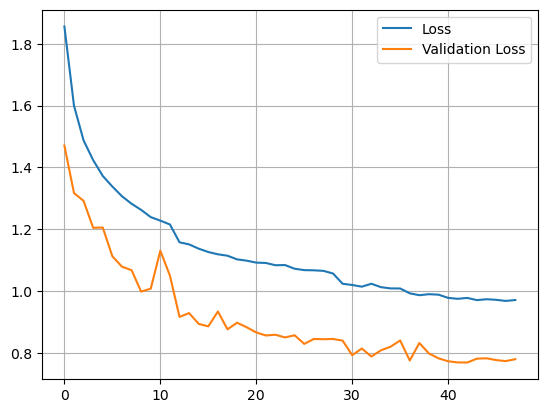

In [124]:
plt.plot(history.history["loss"], label="Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.grid()
plt.show()

In [125]:
test_scores = model.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {test_scores[0]:.2f}")
print(f"Test accuracy: {test_scores[1]:.2f}")

Test loss: 0.79
Test accuracy: 0.73


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


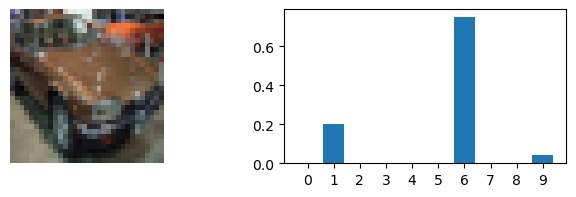

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


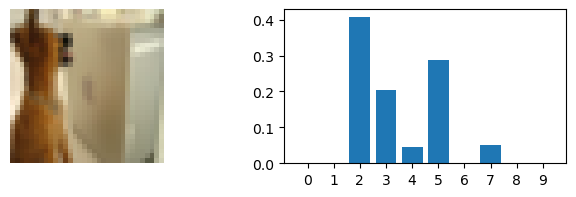

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


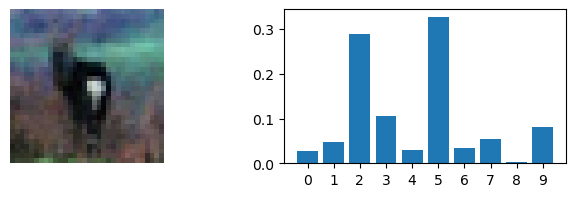

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


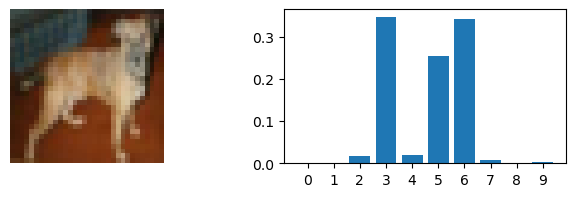

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


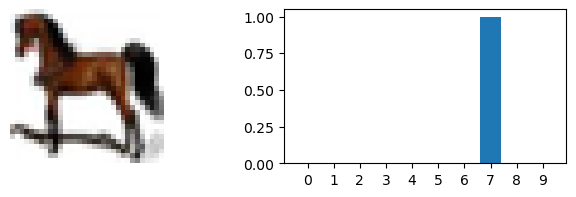

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


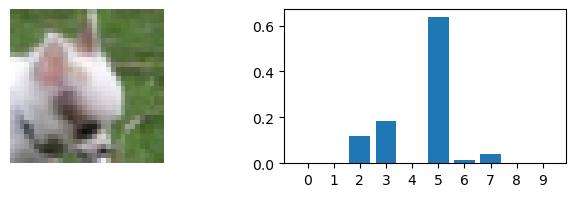

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


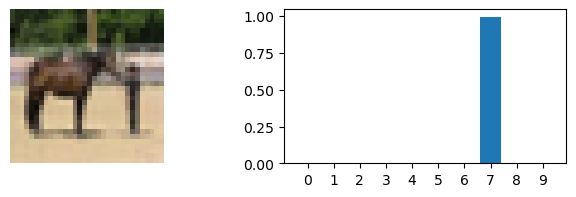

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


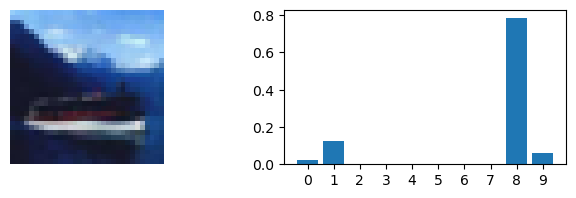

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


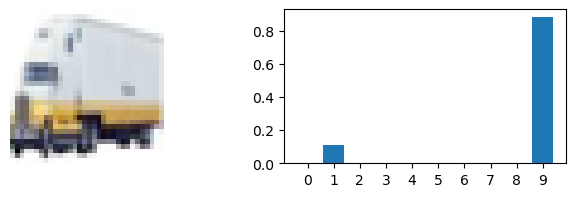

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


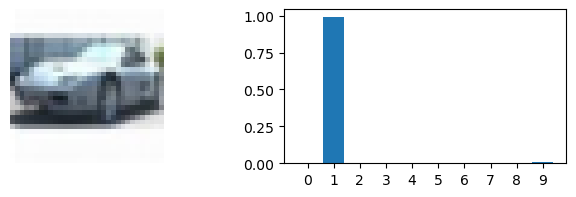

In [126]:
start = 2000

for k in range(10):
    plt.figure(figsize=(8, 2))

    # Get one image
    x = np.expand_dims(X_test[start + k], axis=0)

    # Predict
    y = model.predict(x)[0]

    # Show the image
    plt.subplot(1, 2, 1)
    plt.imshow(X_test[start + k])
    plt.axis("off")

    # Show the prediction probabilities
    plt.subplot(1, 2, 2)
    plt.bar(np.arange(10), y)
    plt.xticks(range(10))

    plt.show()